In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from numpy import meshgrid
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.autograd import gradcheck
from numpy import exp, mod, meshgrid, cos, sin, exp, pi
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import shift
from math import sqrt
from scipy.sparse import diags
from scipy.linalg import cholesky

import os
impath = "./data/Crossing_waves/mac/"
immpath = "./plots/Crossing_waves/mac/"
os.makedirs(impath, exist_ok=True)
os.makedirs(immpath, exist_ok=True)

# Crossing waves example

## Create data for example model

In [2]:
Nx, Nt, sigma = 400, 200, 4.0
coefficients1 = [0.15,0,0.8,1.5]
coefficients2 = [-18,2]
seed = 27
center_matrix3 = 200

In [3]:
np.random.seed(seed)
torch.manual_seed(seed)

In [4]:
def generate_data(Nx, Nt, coeff1, coeff2, center1, center2, sigma_slope=0.1, sigma_base=4.0):
    sigma = 5.0
    x = np.arange(0, Nx)
    t = np.linspace(-10,10, Nt)
    t_max = np.max(t)
    [X, T] = np.meshgrid(x, t)
    X = X.T
    T = T.T    

    def gaussian(x, mu, sigma=1.0):
        return np.exp(-np.power(x - mu, 2.0) / (2 * np.power(sigma, 2.0)))

    q1 = np.zeros_like(X, dtype=np.float64)
    q2 = np.zeros_like(X, dtype=np.float64)
    shift1 = np.polyval(coeff1, t)
    shift2 = np.polyval(coeff2, t)
    for col in range(Nt):
        sigma_t = sigma_base 
        for row in range(Nx):
            q1[row, col] = sin(pi * t[col] / t_max) * gaussian(row, center1 + shift1[col], sigma_t)
            q2[row, col] = cos(pi * t[col] / t_max) * gaussian(row, center2 + shift2[col], sigma_t)
    
    Q = q1 + q2
    Q /= Q.max()
    
    return Q, x, t

In [5]:
Q,x,t = generate_data(Nx, Nt, coefficients1, coefficients2, center_matrix3, center_matrix3, sigma_base=sigma)

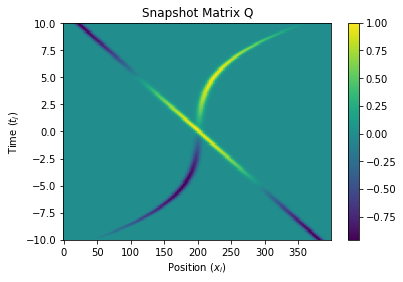

In [6]:
X, T = np.meshgrid(x, t)

plt.pcolormesh(X.T, T.T, Q)
plt.colorbar()
plt.xlabel('Position ($x_i$)')
plt.ylabel('Time ($t_j$)')
plt.title('Snapshot Matrix Q')
plt.show()

In [7]:
def save_fig(filepath, figure=None, **kwargs):
    import tikzplotlib
    import os
    import matplotlib.pyplot as plt

    ## split extension
    fpath = os.path.splitext(filepath)[0]
    ## get figure handle
    if figure is None:
        figure = plt.gcf()
    figure.savefig(fpath + ".png", dpi=300, transparent=True)
    tikzplotlib.save(
        figure=figure,
        filepath=fpath + ".tex",
        axis_height='\\figureheight',
        axis_width='\\figurewidth',
        override_externals=True,
        **kwargs
    )

## Define inputs

In [8]:
np.random.seed(seed)
torch.manual_seed(seed)

In [9]:
inputs = np.stack([x.repeat(Nt), np.tile(t, Nx)], axis=1)
inputs_tensor = torch.tensor(inputs, dtype=torch.float32)
Q_tensor = torch.tensor(Q)

## Define a model

In [10]:
class NuclearNormAutograd(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input_matrix):
        ctx.save_for_backward(input_matrix)
        return torch.linalg.matrix_norm(input_matrix, ord="nuc")

    @staticmethod
    def backward(ctx, grad_output):
        input_matrix, = ctx.saved_tensors
        u, s, v = torch.svd(input_matrix, some=False)
        rank = torch.sum(s > 0).item()
        dtype = input_matrix.dtype
        eye_approx = torch.diag((s > 0).to(dtype)[:rank])
        grad_input = torch.matmul(torch.matmul(u[:, :rank], eye_approx), v[:, :rank].t())
        return grad_input * grad_output.unsqueeze(-1).unsqueeze(-1)

In [11]:
class ShapeShiftNet(nn.Module):
    def __init__(self):
        super(ShapeShiftNet, self).__init__()
        self.elu = nn.ELU()
        
        # Subnetwork for f^1 and shift^1
        self.f1_fc1 = nn.Linear(2, 5)
        self.f1_fc2 = nn.Linear(5, 10)
        self.f1_fc3 = nn.Linear(10, 5)
        self.f1_fc4 = nn.Linear(5, 1)
        
        self.shift1_fc1 = nn.Linear(1, 5)
        self.shift1_fc2 = nn.Linear(5, 5)
        self.shift1_fc3 = nn.Linear(5, 1)


        # Subnetwork for f^2 and shift^2
        self.f2_fc1 = nn.Linear(2, 5)
        self.f2_fc2 = nn.Linear(5, 10)
        self.f2_fc3 = nn.Linear(10, 5)
        self.f2_fc4 = nn.Linear(5, 1)
        
        self.shift2_fc1 = nn.Linear(1, 5)
        self.shift2_fc2 = nn.Linear(5, 5)
        self.shift2_fc3 = nn.Linear(5, 1)

        
    def forward(self, x, t):
        # Pathway for f^1 and shift^1
        shift1 = self.elu(self.shift1_fc1(t))
        shift1 = self.elu(self.shift1_fc2(shift1))
        shift1 = self.shift1_fc3(shift1)

        x_shifted1 = x + shift1
        f1 = self.elu(self.f1_fc1(torch.cat((x_shifted1, t), dim=1)))
        f1 = self.elu(self.f1_fc2(f1))
        f1 = self.elu(self.f1_fc3(f1))
        f1 = self.f1_fc4(f1)
        
        f1_without_shift = self.elu(self.f1_fc1(torch.cat((x, t), dim=1)))
        f1_without_shift = self.elu(self.f1_fc2(f1_without_shift))
        f1_without_shift = self.elu(self.f1_fc3(f1_without_shift))
        f1_without_shift = self.f1_fc4(f1_without_shift)
        
        
        # Pathway for f^2 and shift^2
        shift2 = self.elu(self.shift2_fc1(t))
        shift2 = self.elu(self.shift2_fc2(shift2))
        shift2 = self.shift2_fc3(shift2)

        x_shifted2 = x + shift2
        f2 = self.elu(self.f2_fc1(torch.cat((x_shifted2, t), dim=1)))
        f2 = self.elu(self.f2_fc2(f2))
        f2 = self.elu(self.f2_fc3(f2))
        f2 = self.f2_fc4(f2)
        
        f2_without_shift = self.elu(self.f2_fc1(torch.cat((x, t), dim=1)))
        f2_without_shift = self.elu(self.f2_fc2(f2_without_shift))
        f2_without_shift = self.elu(self.f2_fc3(f2_without_shift))
        f2_without_shift = self.f2_fc4(f2_without_shift)
        
        return f1, f2, shift1, shift2, f1_without_shift, f2_without_shift, shift1, shift2

In [12]:
model = ShapeShiftNet()

pretrained_load = True
if pretrained_load:
    state_dict_original = torch.load("./data/Crossing_waves/seed=27/Crossing_waves.pth")
    state_dict_new = model.state_dict()
    
    for name, param in state_dict_original.items():
        if name in state_dict_new:
            state_dict_new[name].copy_(param)
    model.load_state_dict(state_dict_new, strict=False)


optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [13]:
num_epochs = 1000
lambda_k = 0.5

for epoch in range(num_epochs + 1):
    x_flat, t_flat = inputs_tensor[:, 0:1], inputs_tensor[:, 1:2]
    optimizer.zero_grad()
    f1_full, f2_full, shift1_pred, shift2_pred, f1_full_nos, f2_full_nos, s1, s2 = model(x_flat, t_flat)
    
    frobenius_loss = torch.norm(Q_tensor - f1_full.view(Nx, Nt) - f2_full.view(Nx, Nt), 'fro') ** 2
    
    nuclear_loss_q1 = NuclearNormAutograd.apply(f1_full_nos.view(Nx, Nt))
    nuclear_loss_q2 = NuclearNormAutograd.apply(f2_full_nos.view(Nx, Nt))
    nuclear_loss = lambda_k*(nuclear_loss_q1 + nuclear_loss_q2)
    
    total_loss = frobenius_loss + nuclear_loss

    total_loss.backward(retain_graph=True)
    optimizer.step()

    if frobenius_loss < 1:
        print("Early stopping is triggered")
        break
    
    if epoch % 100 == 0:
        print(
            f'Epoch {epoch}/{num_epochs}, Frob Loss: {frobenius_loss.item()}, Nuclear Loss: {nuclear_loss.item()}, Total loss: {total_loss.item()},')

Epoch 0/1000, Frob Loss: 1.0196120090166456, Nuclear Loss: 54.04690170288086, Total loss: 55.06651371189751,
Epoch 100/1000, Frob Loss: 2.0643849006379535, Nuclear Loss: 52.0303840637207, Total loss: 54.09476896435866,
Epoch 200/1000, Frob Loss: 2.102300267254818, Nuclear Loss: 51.972286224365234, Total loss: 54.07458649162005,
Epoch 300/1000, Frob Loss: 2.1197128345009513, Nuclear Loss: 51.939964294433594, Total loss: 54.059677128934545,
Epoch 400/1000, Frob Loss: 2.1250266251329806, Nuclear Loss: 51.98928451538086, Total loss: 54.11431114051384,
Epoch 500/1000, Frob Loss: 2.1664693877973282, Nuclear Loss: 51.9548454284668, Total loss: 54.121314816264125,
Epoch 600/1000, Frob Loss: 2.1560914393802073, Nuclear Loss: 51.898651123046875, Total loss: 54.05474256242708,
Epoch 700/1000, Frob Loss: 2.159940739738868, Nuclear Loss: 51.877296447753906, Total loss: 54.03723718749278,
Epoch 800/1000, Frob Loss: 2.1651873209613335, Nuclear Loss: 51.840782165527344, Total loss: 54.00596948648868,


In [14]:
combined = f1_full + f2_full
Q_tilde = combined.view(Nx, Nt).detach().numpy()

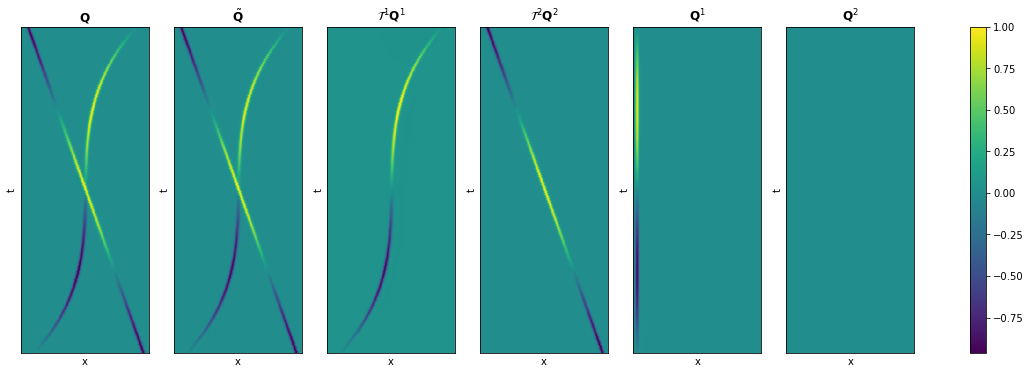

In [15]:
fig, axs = plt.subplots(1, 6, figsize=(20, 6))
vmin = np.min(Q)
vmax = np.max(Q)

axs[0].pcolormesh(X.T, T.T, Q, vmin=vmin, vmax=vmax)
axs[0].set_title(r"${\mathbf{Q}}$")
axs[0].set_xlabel("x")
axs[0].set_ylabel("t")
axs[0].set_xticks([])
axs[0].set_yticks([])

#Qtilde
axs[1].pcolormesh(X.T, T.T, Q_tilde, vmin=vmin, vmax=vmax)
axs[1].set_title(r"$\tilde{\mathbf{Q}}$")
axs[1].set_xlabel("x")
axs[1].set_ylabel("t")
axs[1].set_xticks([])
axs[1].set_yticks([])

# f^1
axs[2].pcolormesh(X.T, T.T, f1_full.view(Nx, Nt).detach().numpy(), vmin=vmin)
axs[2].set_title(r"$\mathcal{T}^1\mathbf{Q}^1$")
axs[2].set_xlabel("x")
axs[2].set_ylabel("t")
axs[2].set_xticks([])
axs[2].set_yticks([])

# f^2
axs[3].pcolormesh(X.T, T.T, f2_full.view(Nx,Nt).detach().numpy(), vmin=vmin, vmax=vmax)
axs[3].set_title(r"$\mathcal{T}^2\mathbf{Q}^2$")
axs[3].set_xlabel("x")
axs[3].set_ylabel("t")
axs[3].set_xticks([])
axs[3].set_yticks([])

# f^1
axs[4].pcolormesh(X.T, T.T, f1_full_nos.view(Nx,Nt).detach().numpy(), vmin=vmin, vmax=vmax)
axs[4].set_title(r"$\mathbf{Q}^1$")
axs[4].set_xlabel("x")
axs[4].set_ylabel("t")
axs[4].set_xticks([])
axs[4].set_yticks([])

# f^2
cax4 = axs[5].pcolormesh(X.T, T.T, f2_full_nos.view(Nx,Nt).detach().numpy(), vmin=vmin, vmax=vmax)
axs[5].set_title(r"$\mathbf{Q}^2$")
axs[5].set_xlabel("x")
axs[5].set_ylabel("t")
axs[5].set_xticks([])
axs[5].set_yticks([])

plt.colorbar(cax4, ax=axs.ravel().tolist(), orientation='vertical')

In [ ]:
save_fig(filepath=immpath + "Crossing_waves_NN", figure=fig)

## Saving the results

In [ ]:
torch.save(model.state_dict(), impath + 'Crossing_waves.pth')
np.save(impath + 'Q.npy', Q)
np.save(impath + 'Q_tilde.npy', Q_tilde)
np.save(impath + 'T1Q1.npy', f1_full.view(Nx, Nt).detach().numpy())
np.save(impath + 'T2Q2.npy', f2_full.view(Nx, Nt).detach().numpy())
np.save(impath + 'Q1.npy', f1_full_nos.view(Nx, Nt).detach().numpy())
np.save(impath + 'Q2.npy', f2_full_nos.view(Nx, Nt).detach().numpy())
np.save(impath + 'shifts1.npy', s1.detach().numpy()[:Nt]) 
np.save(impath + 'shifts2.npy', s2.detach().numpy()[:Nt]) 

# Apply rsPOD taking the results from the above as initial guesses


In [ ]:
import sys

sys.path.append("./sPOD/lib/")

import numpy as np
from numpy import meshgrid
import matplotlib.pyplot as plt
from sPOD_algo import (
    shifted_POD,
    sPOD_Param,
    give_interpolation_error,
)
from transforms import Transform
from plot_utils import save_fig

In [ ]:
# Load the data
Q = np.load(impath + 'Q.npy')
Q_tilde = np.load(impath + 'Q_tilde.npy')
T1Q1 = np.load(impath + 'T1Q1.npy')
T2Q2 = np.load(impath + 'T2Q2.npy')
Q1 = np.load(impath + 'Q1.npy')
Q2 = np.load(impath + 'Q2.npy')
shifts1 = np.load(impath + 'shifts1.npy')
shifts2 = np.load(impath + 'shifts2.npy') 

In [ ]:
err = np.linalg.norm(Q - Q_tilde) / np.linalg.norm(Q)
print("NN prediction error: %1.2e " % err)

In [ ]:
plt.plot(shifts2 + 400)
plt.show()

In [ ]:
# Prepare the transformations
L = x[-1]
dx = x[1] - x[0]
s1 = np.polyval(shifts1, t)
s2 = np.polyval(shifts2 + 400, t)

data_shape = [Nx, 1, 1, Nt]
transfos = [
    Transform(data_shape, [L], shifts=s1, dx=[dx], interp_order=5),
    Transform(data_shape, [L], shifts=s2, dx=[dx], interp_order=5),
]

interp_err = np.max([give_interpolation_error(Q, trafo) for trafo in transfos])
print("interpolation error: %1.2e " % interp_err)

In [ ]:
METHOD = "ALM"

# Parameters
mu0 = Nx * Nt / (4 * np.sum(np.abs(Q))) * 0.003
lambd0 = 1 / np.sqrt(np.maximum(Nx, Nt))
myparams = sPOD_Param()
myparams.maxit = 28
param_alm = mu0  # adjust for case

In [ ]:
# Call the ALM method
ret = shifted_POD(Q, transfos, [1, 1], myparams, METHOD, param_alm, [T1Q1, T2Q2])

In [ ]:
sPOD_frames, qtilde, rel_err = ret.frames, ret.data_approx, ret.rel_err_hist
qf = [
    np.squeeze(np.reshape(transfo.apply(frame.build_field()), data_shape))
    for transfo, frame in zip(transfos, sPOD_frames)
]

In [ ]:
# %% 1. visualize your results: sPOD frames
############################################

fig, axs = plt.subplots(1, 4, figsize=(20, 6))
vmin = np.min(Q)
vmax = np.max(Q)

axs[0].pcolormesh(X.T, T.T, Q, vmin=vmin, vmax=vmax)
axs[0].set_title(r"${\mathbf{Q}}$")
axs[0].set_xlabel("x")
axs[0].set_ylabel("t")
axs[0].set_xticks([])
axs[0].set_yticks([])

#Qtilde
axs[1].pcolormesh(X.T, T.T, qtilde, vmin=vmin, vmax=vmax)
axs[1].set_title(r"$\tilde{\mathbf{Q}}$")
axs[1].set_xlabel("x")
axs[1].set_ylabel("t")
axs[1].set_xticks([])
axs[1].set_yticks([])

# f^1
axs[2].pcolormesh(X.T, T.T, qf[0], vmin=vmin)
axs[2].set_title(r"$\mathcal{T}^1\mathbf{Q}^1$")
axs[2].set_xlabel("x")
axs[2].set_ylabel("t")
axs[2].set_xticks([])
axs[2].set_yticks([])

# f^2
cax3 = axs[3].pcolormesh(X.T, T.T, qf[1], vmin=vmin, vmax=vmax)
axs[3].set_title(r"$\mathcal{T}^2\mathbf{Q}^2$")
axs[3].set_xlabel("x")
axs[3].set_ylabel("t")
axs[3].set_xticks([])
axs[3].set_yticks([])

plt.colorbar(cax3, ax=axs.ravel().tolist(), orientation='vertical')

In [ ]:
save_fig(filepath=immpath + "Crossing_waves_sPOD", figure=fig)